# Analysis of Financial Documents to Forecast Stock Prices

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stock_predictions = pd.read_csv('/content/NEWS_YAHOO_stock_prediction.csv')
stock_predictions.head()

,Unnamed: 0,ticker,Date,category,title,content,Open,High,Low,Close,Adj Close,Volume,label
0,0,AAPL,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
1,1,AAPL,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
2,2,AAPL,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
3,3,AAPL,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
4,4,AAPL,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0


Filter out the opinion articles to see if there is any change in test accuracy.

In [ ]:
#stock_predictions = stock_predictions[:5000]
stock_predictions = stock_predictions[stock_predictions["category"]=="news"]
stock_predictions.shape

(5488, 13)

In [ ]:
stock_predictions['length'] = list(map(lambda x: len(str(x).split(' ')),stock_predictions['content']))
stock_predictions.head()

,Unnamed: 0,ticker,Date,category,title,content,Open,High,Low,Close,Adj Close,Volume,label,length
6,6,AAPL,2020-01-27,news,Stocks Europe Seen Opening Lower as Virus Co...,By Peter Nurse \nInvesting com European stoc...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0,579
7,7,AAPL,2020-01-27,news,Intelligent Systems wins bullish rating from B...,BTIG analyst Mark Palmer initiates coverage of...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0,135
11,11,AAPL,2020-01-24,news,Earnings Outlook Apple earnings A year after...,What a difference a year makes After flubbin...,80.062500,80.832497,79.379997,79.577499,78.089607,146537600,0,2878
13,13,AAPL,2020-01-24,news,Apple gets 400 target on 5G cycle,Wedbush analyst Dan Ives raises his Apple NAS...,80.062500,80.832497,79.379997,79.577499,78.089607,146537600,0,96
14,14,AAPL,2020-01-24,news,Take Five When China sneezes,Reuters 1 OUTBREAK\nWuhan in central China...,80.062500,80.832497,79.379997,79.577499,78.089607,146537600,0,1242


In [ ]:
print(stock_predictions['label'].corr(stock_predictions['length']))

-0.02822006569745636


<Axes: xlabel='category', ylabel='count'>

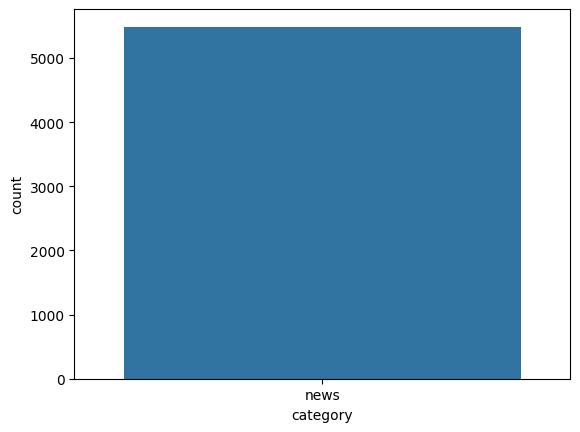

In [ ]:
sns.countplot(x='category', data=stock_predictions)

In [ ]:
!pip install text_hammer
import text_hammer as th
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.18 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [ ]:
content = stock_predictions['content'].copy()[:]
content = content.to_list()
content = list(map(lambda x: x.lower(), content))
#content = list(map(lambda x: th.cont_exp(x), content))
content = list(map(lambda x: th.remove_emails(x), content))
content = list(map(lambda x: th.remove_emails(x), content))
content = list(map(lambda x: th.remove_html_tags(x),content))
content = list(map(lambda x: th.remove_stopwords(x), content))
content = list(map(lambda x: th.remove_special_chars(x), content))
content = list(map(lambda x: th.remove_accented_chars(x), content))
#content = list(map(lambda x: th.make_base(x), content))

In [ ]:
content[:1]

['peter nurse investing com european stock markets set open sharply lower monday following weakness asia caused sharp escalation chinese measures curtail spread deadly coronavirus 02 15 et 0715 gmt dax futures contract traded 137 points 1 lower france s cac 40 futures 72 points 1 2 ftse 100 futures contract u k dropped 63 points 0 9 futures pan eurozone index euro stoxx 50 fell 40 points 1 1 markets mainland china hong kong shut japan s nikkei 225 closed 2 lower brent crude futures continues tumble hitting lowest level october traders priced hit chinese demand gold futures government bonds rallied according recent clinical information virus s ability spread getting somewhat stronger china s national health commission minister ma xiaowei said press briefing sunday adding infectious incubation period e symptoms making harder contain nearly 2 000 people china infected 56 killed disease ma said sunday reuters reported later death toll increased 80 number confirmed cases 2 744 week numbers 

In [ ]:
pairs = []
for doc in tqdm(content):
  pairs.extend(nltk.word_tokenize(doc))
freq = nltk.FreqDist(pairs)
freq.most_common(10)

  0%|          | 0/5488 [00:00<?, ?it/s]

[('s', 39385),
 ('said', 18407),
 ('apple', 17878),
 ('nasdaq', 9691),
 ('percent', 9550),
 ('u', 9484),
 ('1', 8309),
 ('year', 8052),
 ('company', 7914),
 ('0', 7324)]

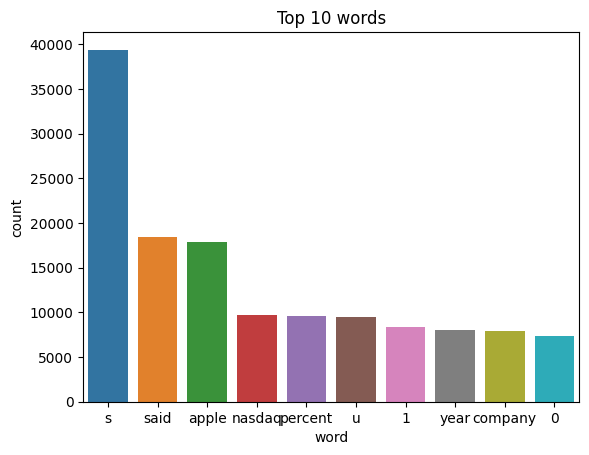

In [ ]:
words_df = pd.DataFrame(freq.most_common(10),  columns=['word', 'count'])
sns.barplot(x='word',y='count',data= words_df)
plt.title("Top 10 words")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
#from keras.utils.all_utils import to_categorical
from keras.utils import to_categorical
Y = to_categorical(stock_predictions['label'])
X = content.copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 40000
tokenizer = Tokenizer(num_words, lower=True)
df_total = pd.concat([pd.Series(X_train), pd.Series(X_test)], axis=0)
tokenizer.fit_on_texts(df_total)

In [ ]:
from keras.utils import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=400,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 400, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(3841, 400) (1647, 400)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Embedding, Dropout

In [ ]:
lstm_ffnn = Sequential()
lstm_ffnn.add(Embedding(input_dim=num_words, output_dim=100, input_length=X_train_pad.shape[1]))
lstm_ffnn.add(Dropout(0.2))
lstm_ffnn.add(Bidirectional(LSTM(128, return_sequences=False)))
lstm_ffnn.add(Dropout(0.2))
lstm_ffnn.add(Dense(64, activation='tanh'))
lstm_ffnn.add(Dense(32, activation='tanh'))
lstm_ffnn.add(Dense(2, activation='sigmoid'))

In [ ]:
lstm_ffnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
lstm_ffnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 100)          4000000   
                                                                 
 dropout_4 (Dropout)         (None, 400, 100)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                      

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
lstm_history = lstm_ffnn.fit(X_train_pad, Y_train, epochs = 5, batch_size = 64, validation_data=(X_test_pad, Y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/5
61/61 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5108
Epoch 1: val_accuracy improved from -inf to 0.52641, saving model to ./model.h5
61/61 [==============================] - 30s 404ms/step - loss: 0.6935 - accuracy: 0.5108 - val_loss: 0.6919 - val_accuracy: 0.5264
Epoch 2/5
61/61 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.6287
Epoch 2: val_accuracy did not improve from 0.52641
61/61 [==============================] - 14s 230ms/step - loss: 0.6592 - accuracy: 0.6287 - val_loss: 0.7498 - val_accuracy: 0.5246
Epoch 3/5
61/61 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.8037
Epoch 3: val_accuracy did not improve from 0.52641
61/61 [==============================] - 14s 221ms/step - loss: 0.4410 - accuracy: 0.8037 - val_loss: 0.9335 - val_accuracy: 0.5003
Epoch 4/5
61/61 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9263
Epoch 4: val_accuracy did not improve from 0.52641

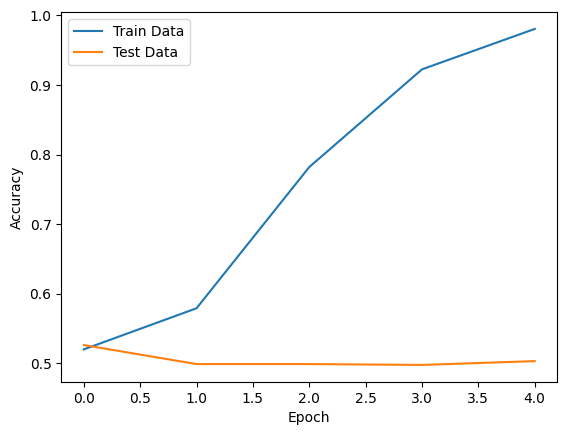

In [ ]:
plt.plot(lstm_history.history['accuracy'], label='Train Data')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
lstm_ffnn.predict(X_train_pad)

121/121 [==============================] - 3s 12ms/step


array([[0.9968919 , 0.00225616],
       [0.01123586, 0.98888236],
       [0.99154705, 0.00833157],
       ...,
       [0.9956037 , 0.00372138],
       [0.00322428, 0.9976707 ],
       [0.00521121, 0.99549943]], dtype=float32)

In [ ]:
Y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

52/52 [==============================] - 1s 10ms/step


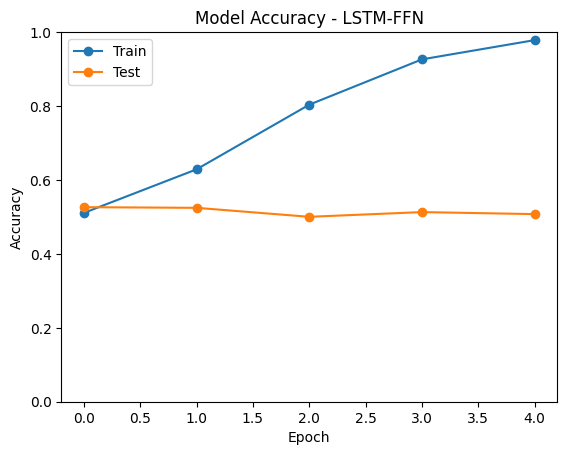

Train metrics:
Accuracy: 0.9891
Precision: 0.9901
Recall: 0.9891
F1-Score: 0.9896

Test metrics:
Accuracy: 0.5076
Precision: 0.5320
Recall: 0.5363
F1-Score: 0.5342


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import matplotlib.pyplot as plt

model = lstm_ffnn
history = lstm_history

train_preds = model.predict(X_train_pad)
test_preds = model.predict(X_test_pad)

train_preds = np.argmax(train_preds, axis=1)
test_preds = np.argmax(test_preds, axis=1)

train_metrics = {
    'accuracy': accuracy_score(np.argmax(Y_train, axis=1), train_preds),
    'precision': precision_score(np.argmax(Y_train, axis=1), train_preds),
    'recall': recall_score(np.argmax(Y_train, axis=1), train_preds),
    'f1': f1_score(np.argmax(Y_train, axis=1), train_preds)
}

test_metrics = {
    'accuracy': accuracy_score(np.argmax(Y_test, axis=1), test_preds),
    'precision': precision_score(np.argmax(Y_test, axis=1), test_preds),
    'recall': recall_score(np.argmax(Y_test, axis=1), test_preds),
    'f1': f1_score(np.argmax(Y_test, axis=1), test_preds)
}


tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='Train', marker='o')
ax.plot(history.history['val_accuracy'], label='Test', marker='o')
ax.set_ylim(0, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy - LSTM-FFN')
ax.legend()

plt.savefig('accuracy.png', dpi=300)
plt.show()

print("Train metrics:")
print(f"Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1-Score: {train_metrics['f1']:.4f}")

print("\nTest metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1']:.4f}")

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras_visualizer import visualizer
visualizer(model, file_name='graph', file_format="png", view=True, settings=None)